In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore', category=Warning)
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.titlesize': 16, 'axes.labelsize': 14,
                         'axes.grid': True, 'axes.formatter.use_mathtext': True,
                         'xtick.labelsize': 14, 'xtick.minor.visible': True,
                         'xtick.minor.size': 2, 'xtick.minor.width': 0.6,
                         'xtick.major.size': 3.5, 'xtick.major.width': 0.8,
                         'ytick.labelsize': 14, 'ytick.minor.visible': True,
                         'ytick.minor.size': 2, 'ytick.minor.width': 0.6,
                         'ytick.major.size': 3.5, 'ytick.major.width': 0.8,
                         'legend.fontsize': 14})

if str(Path.cwd().parent) not in sys.path:
    sys.path.append(str(Path.cwd().parent))
if str(Path.cwd().parent.parent) not in sys.path:
    sys.path.append(str(Path.cwd().parent.parent))
if str(Path.cwd().parent.parent.parent) not in sys.path:
    sys.path.append(str(Path.cwd().parent.parent.parent))

from validation.BNN.misc.plots import PDF_Sample
from settings.paths import result_path

Explicações sobre a PDF_Sample:

**PDFs_Dict**: dicionário em que cada item vai ser um modelo
- chave: nome do modelo
- valor: array 1D com tamanho len(amostra de teste). cada elemento desse array vai ser a PDF para cada quasar na amostra de teste (um array com os valores em y da PDF), então vai ter tamanho len(grid da PDF)

**Results_DF**: pandas Dataframe da qual vão ser tiradas as seguintes informações:
- banda r
- redshift espectroscópico
- RA
- DEC
- SDSS name (se tiver)

então, como a função só recebe uma Results_DF, todos os modelos precisam ter essas informações iguais entre si, na mesma ordem, com mesmo índice

**x**: grid das PDFs (precisa ser igual para todos os modelos)

In [2]:
bnn_path = os.path.join(result_path, 'validation', 'bnn')
flex_path = os.path.join(result_path, 'validation', 'flexcode')

## BMDN

In [3]:
def Calc_PDF(x, Weights, Means, STDs):
    '''To calculate PDFs.'''
    if isinstance(Weights, str):
        Weights = np.fromstring(Weights, sep=',')
        Means = np.fromstring(Means, sep=',')
        STDs = np.fromstring(STDs, sep=',')
    PDF = np.sum( Weights * (1/(STDs*np.sqrt(2*np.pi))) * np.exp((-1/2)*((x[:, None]-Means)**2)/(STDs)**2), axis=1 )
    return PDF/np.trapz(PDF, x)

In [4]:
x_bnn = np.genfromtxt(os.path.join(bnn_path, 'crossval_model_dr4_BNWG', 'x.txt'))
models_bnn = {
    'with narrow': pd.read_csv(os.path.join(bnn_path, 'crossval_model_dr4_BNWG', 'Results_DF.csv')),
    'with narrow + flag': pd.read_csv(os.path.join(bnn_path, 'crossval_model_dr4_BNWG_flag', 'Results_DF.csv')),
    'without narrow': pd.read_csv(os.path.join(bnn_path, 'crossval_model_dr4_BWG', 'Results_DF.csv')),
    'without narrow + flag': pd.read_csv(os.path.join(bnn_path, 'crossval_model_dr4_BWG_flag', 'Results_DF.csv'))
    }
pdfs_bnn = {}
for name, table in models_bnn.items():
    pdfs_list = []
    for i in range(len(table)):
        weights = table.loc[i, [f'PDF_Weight_{i}' for i in range(6)]].values.astype(float)
        means = table.loc[i, [f'PDF_Mean_{i}' for i in range(6)]].values.astype(float)
        stds = table.loc[i, [f'PDF_STD_{i}' for i in range(6)]].values.astype(float)
        pdfs_list.append(Calc_PDF(x_bnn, weights, means, stds))
    pdfs_bnn[name] = np.array(pdfs_list)

In [5]:
pdfs_bnn_noflag = {'with narrow': pdfs_bnn['with narrow'],
                   'without narrow': pdfs_bnn['without narrow']}
pdfs_bnn_flag = {'with narrow + flag': pdfs_bnn['with narrow + flag'],
                 'without narrow + flag': pdfs_bnn['without narrow + flag']}

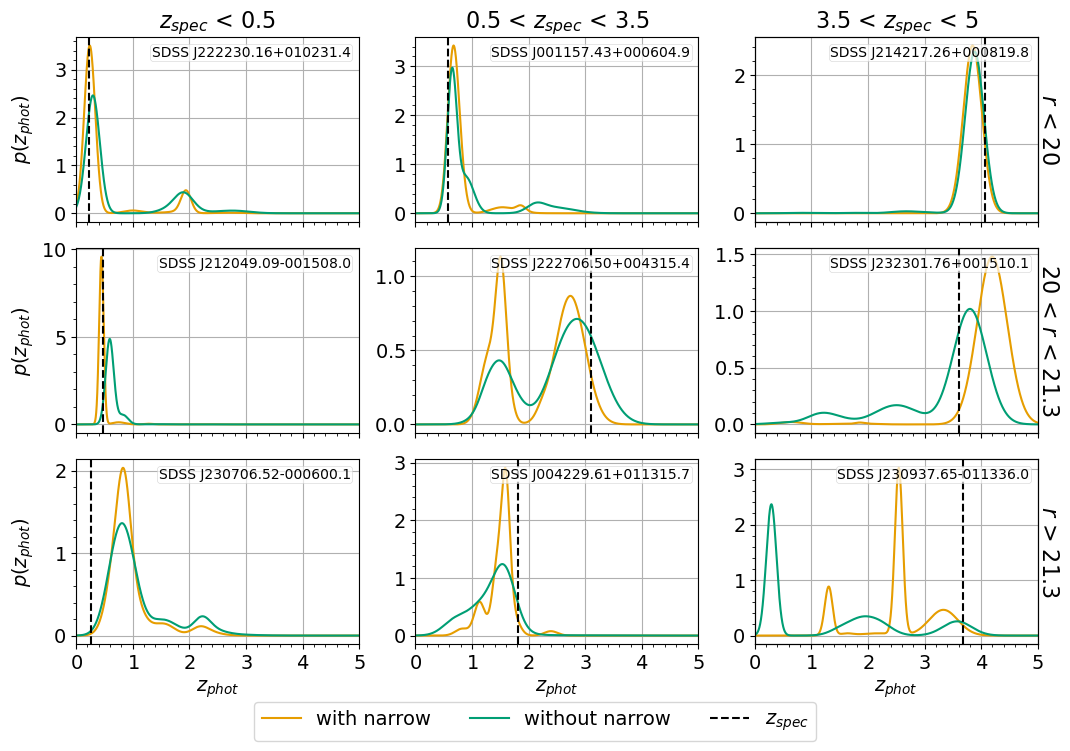

In [6]:
PDF_Sample(models_bnn['with narrow'], pdfs_bnn_noflag, x_bnn, 'PStotal', 47, '',
           False, False, True, True)

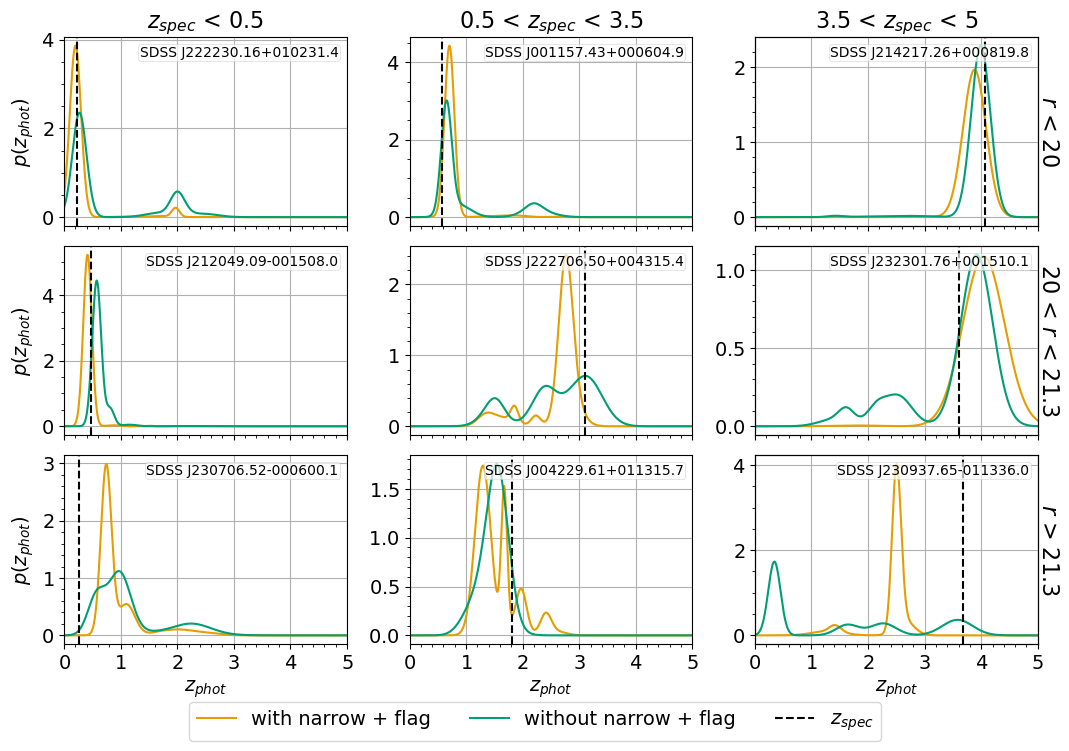

In [7]:
PDF_Sample(models_bnn['with narrow + flag'], pdfs_bnn_flag, x_bnn, 'PStotal', 47, '',
           False, False, True, True)

## FlexCoDE

In [8]:
x_flex = pd.read_csv(os.path.join(flex_path, 'z_grid.csv'), usecols=['x']).x.values
models_flex = {
    '': pd.read_csv(os.path.join(flex_path, 'test_z_broadGALEXWISEnarrowflags.csv'))
    }

pdfs_flex = {}
for name, table in models_flex.items():
    pdfs_list = []
    for i in range(len(table)):
        pdfs_list.append(table.loc[i, [f'z_flex_pdf_{i}' for i in range(1, 201)]].values)
    pdfs_flex[name] = np.array(pdfs_list)

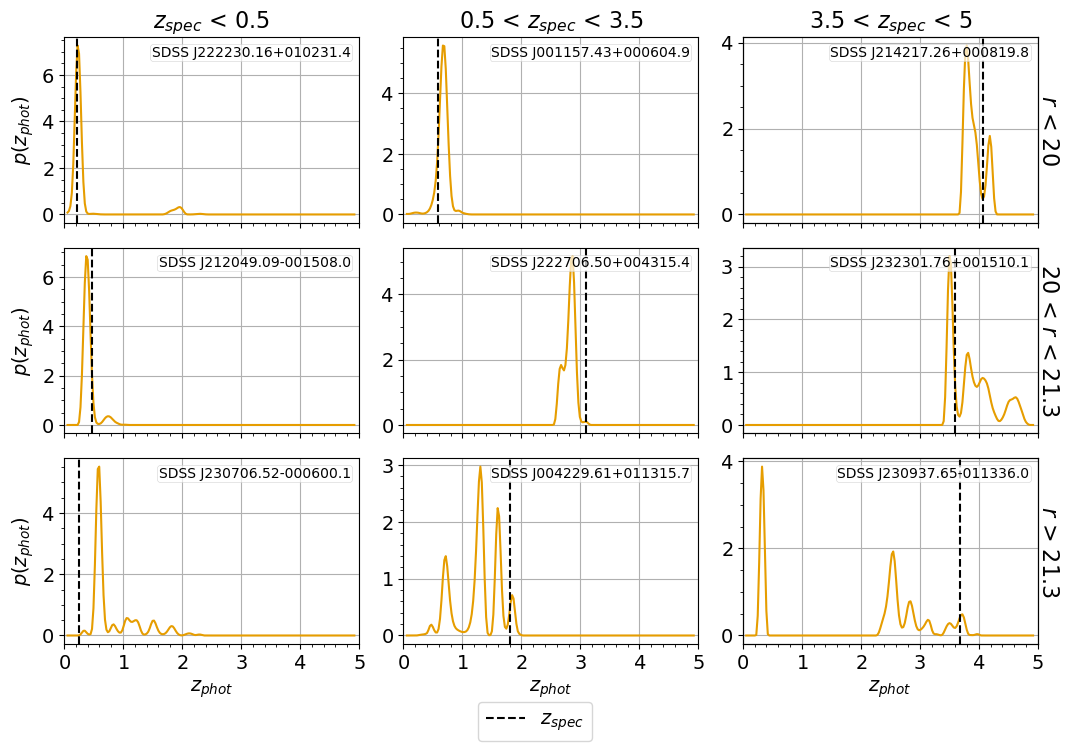

In [13]:
PDF_Sample(pd.concat([models_flex[''], models_bnn['with narrow'][['z', 'r_PStotal', 'SDSS_NAME']]], axis=1),
           pdfs_flex, x_flex, 'PStotal', 47, '', False, False, True, True)

In [10]:
df = pd.read_csv(os.path.join(flex_path, 'test_z_broadGALEXWISEnarrowflags_xmatch.csv'))
names = [
    '204956.61-001201.7', '033821.25+003714.9', '213633.55+004654.5', '221709.80+010029.5',
    '012029.52+003341.6', '232043.35-003049.3', '014531.54-011002.8', '233538.28-005021.5',
    '020538.63+001753.6', '022737.70-011927.0', '023950.51-005725.9', '023737.13-000905.6'
]

In [11]:
for i, name in enumerate(names):
    q = df.query(f"SDSS_NAME == '{name}'")
    if len(q) > 0:
        print(i, name)
        print(q.iloc[0]['z'])

2 213633.55+004654.5
3.727
10 023950.51-005725.9
3.777
